In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

#Load mean_likes and std_likes from npy files
mean_likes = np.load('mean_likes.npy')
std_likes = np.load('std_likes.npy')

In [3]:
BATCH_SIZE = 16
IMG_SIZE = 224

In [4]:
IMAGE_COL = "filename"
NUMERIC_COLS = ["no_of_comments", "t_zeroed", "follower_count_at_t"]
#NUMERIC_COLS = ["no_of_comments"]
TARGET_COL = "likes"

## Plot data graphs

0.002890173410404624
0.0016501650165016502
0.003963011889035667


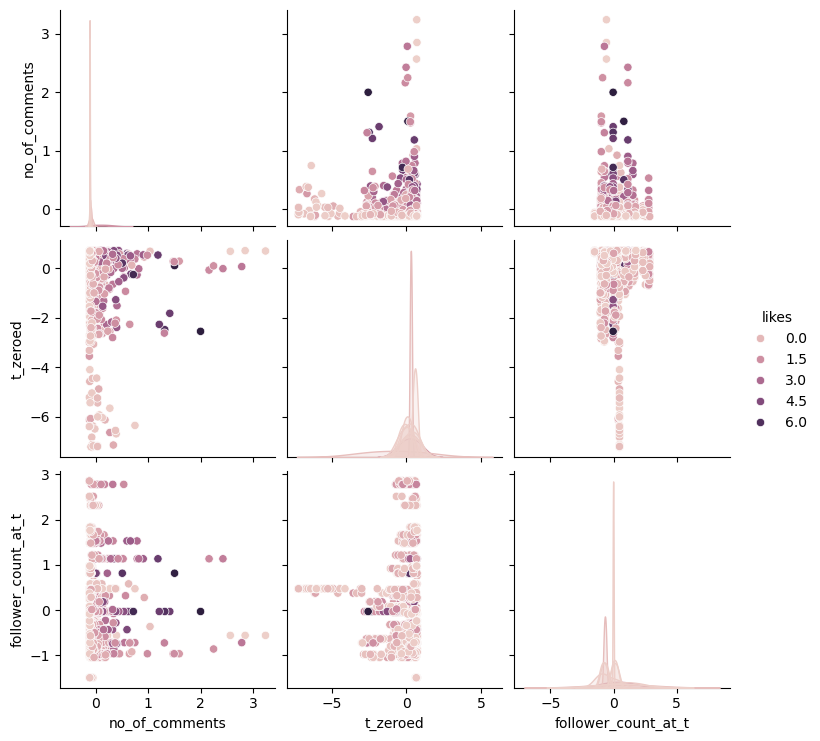

In [5]:
#count no_of_comments values greater than 5 compared to the total number of rows
print(train_df[train_df['no_of_comments'] > 5].shape[0] / train_df.shape[0])
print(val_df[val_df['no_of_comments'] > 5].shape[0] / val_df.shape[0])
print(test_df[test_df['no_of_comments'] > 5].shape[0] / test_df.shape[0])


#remove data points with no_of_comments for values greater than 5
train_df = train_df[train_df['no_of_comments'] <= 5]
val_df = val_df[val_df['no_of_comments'] <= 5]

# Pairplot scatter plot with hue for the target column
import seaborn as sns
sns.pairplot(train_df, y_vars=NUMERIC_COLS, x_vars=NUMERIC_COLS, hue=TARGET_COL)
plt.show()


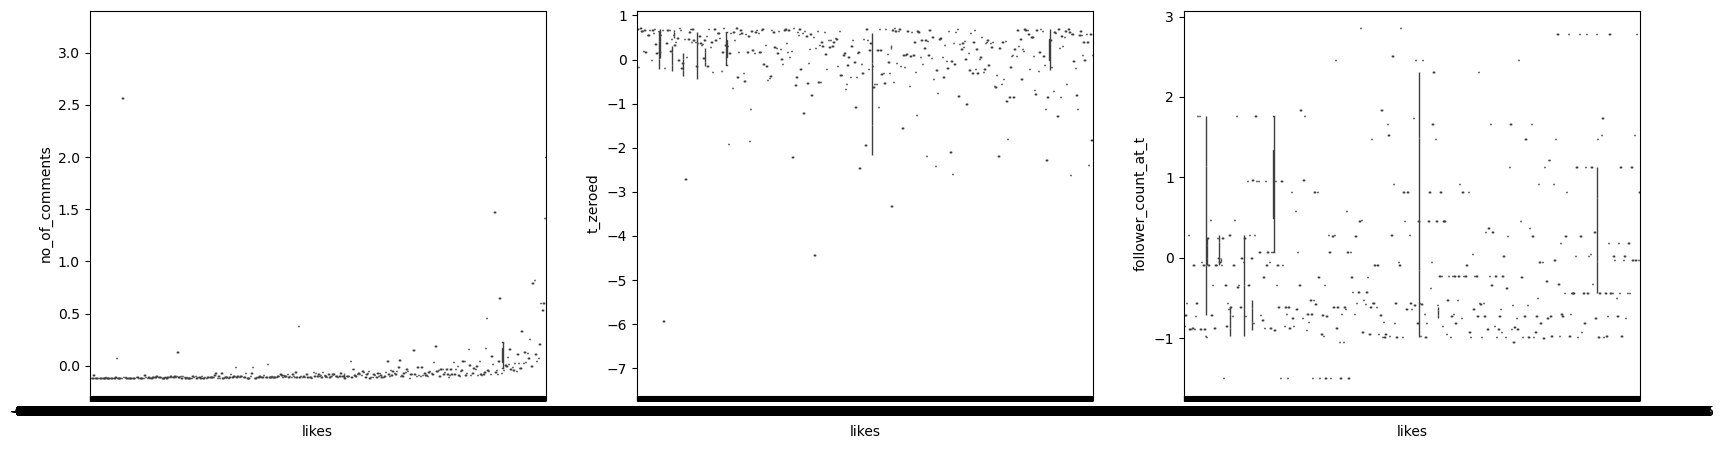

In [6]:
# Box plot each numeric feature with the target column
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(NUMERIC_COLS):
    sns.boxplot(x=TARGET_COL, y=col, data=train_df, ax=axes[i])
plt.show()

In [7]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, img_size, shuffle_data=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle_data = shuffle_data
        self.on_epoch_end()
        self.index = 0

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data after each epoch
        if self.shuffle_data:
            self.df  = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        # Get a batch of data based on the index
        batch_data = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        numerical_features = []
        labels = []

        for _, row in batch_data.iterrows():
            # Load and preprocess the image
            img_path = row[IMAGE_COL]
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.img_size)

            # Normalize the image (scale pixel values to [0, 1])
            image = image / 255.0
            images.append(image)
            
            # Extract numerical features and label
            numerical_feature = row[NUMERIC_COLS].values
            label = row[TARGET_COL]

            numerical_features.append(numerical_feature)
            labels.append(label)

        # Convert lists to numpy arrays
        images = np.array(images)
        numerical_features = np.array(numerical_features)
        labels = np.array(labels)

        # Convert to tensors
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        numerical_features = tf.convert_to_tensor(numerical_features, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)

        # Return the batch: both image and numerical features as inputs, labels as output
        return [images, numerical_features], labels

    
    def __iter__(self):
        """ Return the generator itself as an iterator. """
        self.index = 0  # Reset index when a new iterator is created
        return self

    def __next__(self):
        """ Yield the next batch or raise StopIteration if at the end. """
        if self.index < self.__len__():
            batch = self.__getitem__(self.index)
            self.index += 1
            return batch
        else:
            self.on_epoch_end()  # Shuffle and reset for the next epoch
            raise StopIteration

## Model

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [9]:
def build_DenseNet_model():

    backbone_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # concatenate the output of the backbone and the numerical features
    numerical_features_input = tf.keras.layers.Input(shape=(len(NUMERIC_COLS),))
    concat = tf.keras.layers.Concatenate()([leaky_relu, numerical_features_input])

    # Add a dense layer with 512 units
    dense = tf.keras.layers.Dense(units = 512, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(concat)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # Add a dense layer with 256 units
    dense = tf.keras.layers.Dense(units = 256, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(leaky_relu)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # Add a dense layer with 128 units
    dense = tf.keras.layers.Dense(units = 128, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(leaky_relu)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    # Add the output layer with regression output
    regressor = tf.keras.layers.Dense(units = 1)(leaky_relu)
    
    model = tf.keras.models.Model(inputs = [backbone_model.input, numerical_features_input], outputs = regressor)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    return model

In [10]:
model = build_DenseNet_model()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
training_generator = CustomDataGenerator(train_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))
validation_generator = CustomDataGenerator(val_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))
testing_generator = CustomDataGenerator(test_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))

## Train model

In [13]:
EPOCHS = 50

In [16]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/{epoch:02d}_{val_loss:.3f}_mobilenetv2_3.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [17]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=mycallbacks)

Epoch 1/50


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


151/151 [==============================] - ETA: 0s - loss: 1.4175

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 2.29854, saving model to models\01_2.299_mobilenetv2_3.h5
151/151 [==============================] - 82s 541ms/step - loss: 1.4175 - val_loss: 2.2985 - lr: 0.0010
Epoch 2/50
151/151 [==============================] - ETA: 0s - loss: 1.2252
Epoch 2: val_loss improved from 2.29854 to 2.13465, saving model to models\02_2.135_mobilenetv2_3.h5
151/151 [==============================] - 73s 483ms/step - loss: 1.2252 - val_loss: 2.1347 - lr: 0.0010
Epoch 3/50
151/151 [==============================] - ETA: 0s - loss: 1.1918
Epoch 3: val_loss improved from 2.13465 to 1.15769, saving model to models\03_1.158_mobilenetv2_3.h5
151/151 [==============================] - 75s 492ms/step - loss: 1.1918 - val_loss: 1.1577 - lr: 0.0010
Epoch 4/50
151/151 [==============================] - ETA: 0s - loss: 1.1588
Epoch 4: val_loss did not improve from 1.15769
151/151 [==============================] - 74s 486ms/step - loss: 1.1588 - val_loss: 1.1869 - lr: 0.0010
Ep

In [20]:
# Load the best model
model.load_weights('models/50_0.705_mobilenetv2_3.h5')

In [21]:
# Evaluate the model on the test set
test_loss = model.evaluate(testing_generator)
print(f"Test loss: {test_loss}")

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


48/48 [==============================] - 21s 439ms/step - loss: 5.9988
Test loss: 5.998825550079346


In [23]:
# Predict for 10 samples from the test set
for i in range(10):
    (image, numerical_features), label = testing_generator[i]
    prediction = model.predict([image, numerical_features])
    print(f"Predicted: {prediction[0][0]}, Actual: {label[0]}")
    print(f"Predicted: {prediction[0][0] * std_likes + mean_likes}, Actual: {label[0] * std_likes + mean_likes}")

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 238ms/step
Predicted: 0.25260335206985474, Actual: -0.1914050281047821
Predicted: 232182.06232833606, Actual: 146179.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 239ms/step
Predicted: -0.1555454581975937, Actual: 0.2056688815355301
Predicted: 153124.88829226702, Actual: 223091.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 236ms/step
Predicted: 1.4437003135681152, Actual: 1.2581170797348022
Predicted: 462893.894410604, Actual: 426947.0
1/1 [==============================] - 0s 77ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: -0.16827939450740814, Actual: 0.1337730586528778
Predicted: 150658.363844114, Actual: 209165.0
1/1 [==============================] - 0s 110ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: -0.1288933902978897, Actual: -0.7931646704673767
Predicted: 158287.31218610943, Actual: 29620.0
1/1 [==============================] - 0s 87ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: -0.37354594469070435, Actual: -0.8621022701263428
Predicted: 110898.86198254854, Actual: 16267.0
1/1 [==============================] - 0s 122ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: 1.0434257984161377, Actual: 3.7652037143707275
Predicted: 385361.9472126268, Actual: 912562.0
1/1 [==============================] - 0s 133ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: 0.21129250526428223, Actual: 0.8083062171936035
Predicted: 224180.27787294227, Actual: 339820.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 240ms/step
Predicted: -0.3293359875679016, Actual: -0.7580376267433167
Predicted: 119462.19522390803, Actual: 36424.0
1/1 [==============================] - 0s 123ms/step
Predicted: -0.10407508909702301, Actual: -0.3984656035900116
Predicted: 163094.54108880012, Actual: 106071.9921875


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [24]:
# Fit linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract the features and target
X_train = train_df[NUMERIC_COLS].values
y_train = train_df[TARGET_COL].values

X_val = val_df[NUMERIC_COLS].values
y_val = val_df[TARGET_COL].values

X_test = test_df[NUMERIC_COLS].values
y_test = test_df[TARGET_COL].values

# normalize the numerical featues
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = linear_model.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set
test_predictions = linear_model.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 0.6696535562181447
Test MSE: 7.290294610014335


In [26]:
#Regression with svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Extract the features and target
X_train = train_df[NUMERIC_COLS].values
y_train = train_df[TARGET_COL].values

X_val = val_df[NUMERIC_COLS].values
y_val = val_df[TARGET_COL].values

X_test = test_df[NUMERIC_COLS].values
y_test = test_df[TARGET_COL].values

# Initialize the model
svm_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model
svm_regressor.fit(X_train, y_train)

# Predict on the validation set
val_predictions = svm_regressor.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set

test_predictions = svm_regressor.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 0.4146386990183726
Test MSE: 0.47231405079186783


In [28]:
# Predict for 100 samples from the test set
for i in range(100):
    print(f"Predicted: {test_predictions[i]* std_likes + mean_likes}, Actual: {y_test[i]* std_likes + mean_likes}")
    print(f"Predicted: {test_predictions[i]}, Actual: {y_test[i]}")

Predicted: 61583.56720623991, Actual: 134650.0
Predicted: 220134.39988313147, Actual: 493674.0
Predicted: 128228.0779157526, Actual: 129597.00000000001
Predicted: 77234.51687655278, Actual: 20919.0
Predicted: 132211.3310606145, Actual: 140462.0
Predicted: 186808.87100818547, Actual: 55771.0
Predicted: 180507.06245162516, Actual: 289799.0
Predicted: 108783.25784879625, Actual: 212786.0
Predicted: 109001.73140864683, Actual: 67604.00000000001
Predicted: 79242.16822078323, Actual: 84296.00000000001
Predicted: 66148.05996426352, Actual: 51691.0
Predicted: 145231.6970676256, Actual: 226803.0
Predicted: 54645.19748156445, Actual: 7442.999999999971
Predicted: 289075.8825842089, Actual: 327396.0
Predicted: 87329.81629821836, Actual: 116048.00000000001
Predicted: 212103.64682850946, Actual: 115304.00000000001
Predicted: 86946.3413262068, Actual: 84109.00000000001
Predicted: 405762.70480259927, Actual: 148427.0
Predicted: 126272.91447961691, Actual: 145216.0
Predicted: 74799.24028198449, Actual:

In [36]:
# Fit against only the number of comments

X_train = train_df[["follower_count_at_t", "t_zeroed"]].values
y_train = train_df[TARGET_COL].values

X_val = val_df[["follower_count_at_t", "t_zeroed"]].values
y_val = val_df[TARGET_COL].values

X_test = test_df[["follower_count_at_t", "t_zeroed"]].values
y_test = test_df[TARGET_COL].values

# Initialize the model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = linear_model.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set
test_predictions = linear_model.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 0.9039039839916994
Test MSE: 1.031707123312195


In [37]:
# Predict for 10 samples from the test set
for i in range(10):
    print(f"Predicted: {test_predictions[i]* std_likes + mean_likes}, Actual: {y_test[i]* std_likes + mean_likes}")
    print(f"Predicted: {test_predictions[i]}, Actual: {y_test[i]}")
    

Predicted: -0.00010764214810951231, Actual: -0.2509258429413301
Predicted: -0.08806797776898499, Actual: 1.602608896241292
Predicted: 0.032982860124421844, Actual: -0.2770129876366423
Predicted: 0.05614332341604027, Actual: -0.8380853627003958
Predicted: -0.06389758668978415, Actual: -0.2209202057022335
Predicted: 0.30891381664689727, Actual: -0.6581547933512917
Predicted: -0.15100533512572586, Actual: 0.5500625624283517
Predicted: -0.06651396000318147, Actual: 0.1524672181932274
Predicted: -0.05175894539087092, Actual: -0.5970645136798826
Predicted: 0.4409259201571127, Actual: -0.5108886539422708


In [40]:
#Knn regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Extract the features and target
X_train = train_df[NUMERIC_COLS].values
y_train = train_df[TARGET_COL].values

X_val = val_df[NUMERIC_COLS].values
y_val = val_df[TARGET_COL].values

X_test = test_df[NUMERIC_COLS].values
y_test = test_df[TARGET_COL].values

# Initialize the model
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn_regressor.fit(X_train, y_train)

# Predict on the validation set
val_predictions = knn_regressor.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set
test_predictions = knn_regressor.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")


Validation MSE: 0.3378404183378332
Test MSE: 0.4200937992350442


In [41]:

# Predict for 10 samples from the test set
for i in range(10):
    print(f"Predicted: {test_predictions[i]* std_likes + mean_likes}, Actual: {y_test[i]* std_likes + mean_likes}")
    print(f"Predicted: {test_predictions[i]}, Actual: {y_test[i]}")

Predicted: 40693.600000000006, Actual: 134650.0
Predicted: -0.7359949507684895, Actual: -0.2509258429413301
Predicted: 452493.4, Actual: 493674.0
Predicted: 1.3900056366252667, Actual: 1.602608896241292
Predicted: 200466.0, Actual: 129597.00000000001
Predicted: 0.08886270154049694, Actual: -0.2770129876366423
Predicted: 98187.80000000002, Actual: 20919.0
Predicted: -0.4391693987120434, Actual: -0.8380853627003958
Predicted: 146042.8, Actual: 140462.0
Predicted: -0.19210818569123045, Actual: -0.2209202057022335
Predicted: 155672.0, Actual: 55771.0
Predicted: -0.14239547369833497, Actual: -0.6581547933512917
Predicted: 235082.0, Actual: 289799.0
Predicted: 0.2675748726809935, Actual: 0.5500625624283517
Predicted: 166783.0, Actual: 212786.0
Predicted: -0.08503266651258104, Actual: 0.1524672181932274
Predicted: 190160.6, Actual: 67604.00000000001
Predicted: 0.03565896891768452, Actual: -0.5970645136798826
Predicted: 132112.59999999998, Actual: 84296.00000000001
Predicted: -0.26402568876557